## SYMBOLIC CALCULATION

### Fast Accurate Symbolic Empirical Representation Of Histograms

Name - Shivam Maheshwari

### Task 1. Dataset Preprocessing

**Generating the dataset**

In [1]:
import sympy as sp
import random
import pandas as pd

# Define the symbolic variable
x = sp.Symbol('x', real=True)

base_functions = [
    sp.sin(x), sp.cos(x), sp.exp(x), sp.log(1+x), sp.tan(x),
    sp.sinh(x), sp.cosh(x), sp.asin(x), sp.acos(x), sp.atan(x),
    x, x**2, x**3
]

def generate_random_expression(num_terms=3):

    expr = 0
    for _ in range(num_terms):
        f = random.choice(base_functions)
        coeff = random.randint(-5, 5)
        expr += coeff * f
    return expr

# Number of expressions to generate
num_expressions = 20000

dataset = []
for _ in range(num_expressions):
    terms = random.randint(1, 3)
    expr = generate_random_expression(num_terms=terms)

    # Skip if expression is 0
    if expr == 0:
        continue

    # Compute series expansion around x=0 up to x^4
    # Sympy's 'order=5' generates terms up to x^4, then we remove O(x^5)
    series_expr = sp.series(expr, x, 0, 5).removeO()

    dataset.append((str(expr), str(series_expr)))


df = pd.DataFrame(dataset, columns=["function", "taylor_expansion"])

df.drop_duplicates(inplace=True)

# Save to CSV
df.to_csv("taylor_dataset_extended.csv", index=False)

print(df.head(10))
print(f"Total unique expressions: {len(df)}")


                               function  \
0                               -4*x**2   
1     -5*sin(x) + 2*sinh(x) - 2*atan(x)   
2                  -cosh(x) + 3*asin(x)   
3                             5*acos(x)   
4               -log(x + 1) + 3*asin(x)   
5        5*tan(x) - 5*acos(x) + asin(x)   
6  -2*exp(x) - 3*log(x + 1) + 2*sinh(x)   
7                     -x**3 + 5*atan(x)   
8                       -4*x - 5*exp(x)   
9                     5*exp(x) - tan(x)   

                             taylor_expansion  
0                                     -4*x**2  
1                             11*x**3/6 - 5*x  
2        -x**4/24 + x**3/2 - x**2/2 + 3*x - 1  
3                    -5*x**3/6 - 5*x + 5*pi/2  
4              x**4/4 + x**3/6 + x**2/2 + 2*x  
5                    8*x**3/3 + 11*x - 5*pi/2  
6          2*x**4/3 - x**3 + x**2/2 - 3*x - 2  
7                             -8*x**3/3 + 5*x  
8  -5*x**4/24 - 5*x**3/6 - 5*x**2/2 - 9*x - 5  
9     5*x**4/24 + x**3/2 + 5*x**2/2 + 4*x + 5 

In [ ]:
df_backup = df.copy()

**Tokenising the dataset**

In [2]:
def tokenize_expression(expr):
    return list(expr)

def add_special_tokens(expr):
    # Insert single-character tokens for start/end
    return f"¶{expr}µ"

df["taylor_expansion"] = df["taylor_expansion"].apply(add_special_tokens)

# Create new columns in the DataFrame with token lists
df["function_tokens"] = df["function"].apply(tokenize_expression)
df["taylor_tokens"] = df["taylor_expansion"].apply(tokenize_expression)
print(df.head())

                            function                        taylor_expansion  \
0                            -4*x**2                               ¶-4*x**2µ   
1  -5*sin(x) + 2*sinh(x) - 2*atan(x)                       ¶11*x**3/6 - 5*xµ   
2               -cosh(x) + 3*asin(x)  ¶-x**4/24 + x**3/2 - x**2/2 + 3*x - 1µ   
3                          5*acos(x)              ¶-5*x**3/6 - 5*x + 5*pi/2µ   
4            -log(x + 1) + 3*asin(x)        ¶x**4/4 + x**3/6 + x**2/2 + 2*xµ   

                                     function_tokens  \
0                              [-, 4, *, x, *, *, 2]   
1  [-, 5, *, s, i, n, (, x, ),  , +,  , 2, *, s, ...   
2  [-, c, o, s, h, (, x, ),  , +,  , 3, *, a, s, ...   
3                        [5, *, a, c, o, s, (, x, )]   
4  [-, l, o, g, (, x,  , +,  , 1, ),  , +,  , 3, ...   

                                       taylor_tokens  
0                        [¶, -, 4, *, x, *, *, 2, µ]  
1  [¶, 1, 1, *, x, *, *, 3, /, 6,  , -,  , 5, *, ...  
2  [¶, -, x, *, *

### Task 2: LSTM Model

**Training the LSTM model**

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.models import Model

# 1) Tokenize and Pad
function_texts = df["function"].tolist()
taylor_texts = df["taylor_expansion"].tolist()

# Character-level tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(function_texts + taylor_texts)


input_sequences = tokenizer.texts_to_sequences(function_texts)
output_sequences = tokenizer.texts_to_sequences(taylor_texts)

# debug
for i in range(3):
    print("Original expansion:", taylor_texts[i])
    print("Token IDs:", output_sequences[i][:15])


max_input_length = 50
max_output_length = 50
input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
latent_dim = 128

# right and left shift the decoder
decoder_input_data = np.zeros_like(output_sequences)
decoder_input_data[:, 1:] = output_sequences[:, :-1]

decoder_target_data = np.zeros_like(output_sequences)
decoder_target_data[:, :-1] = output_sequences[:, 1:]
decoder_target_data = np.expand_dims(decoder_target_data, -1)

# 4) Define the Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
_, encoder_hidden_state, encoder_cell_state = encoder_lstm(enc_emb)
encoder_states = [encoder_hidden_state, encoder_cell_state]

# 5) Define the Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm_layer = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm_layer(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 6) Build and Compile the Seq2seq Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

# 7) Train the Model
history_lstm = model.fit(
    [input_sequences, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=100,
    validation_split=0.2
)

Original expansion: ¶-4*x**2µ
Token IDs: [14, 4, 11, 1, 3, 1, 1, 5, 15]
Original expansion: ¶11*x**3/6 - 5*xµ
Token IDs: [14, 20, 20, 1, 3, 1, 1, 6, 10, 22, 2, 4, 2, 13, 1]
Original expansion: ¶-x**4/24 + x**3/2 - x**2/2 + 3*x - 1µ
Token IDs: [14, 4, 3, 1, 1, 11, 10, 5, 11, 2, 7, 2, 3, 1, 1]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 50)       │          1,650 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │          1,650 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │         91,648 │ embedding[0][0]        │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 128),    │         91,648 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 33)       │          4,257 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 190,853 (745.52 KB)

 Trainable params: 190,853 (745.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.9160 - val_loss: 0.7859
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6573 - val_loss: 0.4978
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4602 - val_loss: 0.4390
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4191 - val_loss: 0.4104
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3898 - val_loss: 0.3882
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3729 - val_loss: 0.3693
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3521 - val_loss: 0.3590
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3365 - val_loss: 0.3431
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3215 - val_loss: 0.3324
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3134 - val_loss: 0.3196
Epoch 11/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3027 - val_loss: 0.3139
Epoch 12/100
115/115 ━━━━━━━━━━━━━━

### Task 3: Transformer Model

In [4]:
from tensorflow.keras.layers import LayerNormalization, Dropout, Input, Lambda

# Positional Encoding Function
def get_positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            pos_enc[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
            if i + 1 < d_model:
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i+1)) / d_model)))
    return tf.cast(pos_enc, dtype=tf.float32)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    attn_output = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads
    )(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Transformer Decoder Block with causal masking
def transformer_decoder(inputs, enc_output, head_size, num_heads, ff_dim, dropout=0):
    causal_mask = Lambda(
        lambda x: tf.tile(
            tf.expand_dims(tf.linalg.band_part(tf.ones((tf.shape(x)[1], tf.shape(x)[1])), -1, 0), 0),
            [tf.shape(x)[0], 1, 1]
        )
    )(inputs)

    attn1 = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads
    )(inputs, inputs, attention_mask=causal_mask)
    attn1 = Dropout(dropout)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn1)

    attn2 = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads
    )(out1, enc_output)
    attn2 = Dropout(dropout)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)

    ffn_output = Dense(ff_dim, activation="relu")(out2)
    ffn_output = Dense(out2.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out2 + ffn_output)

# hyperparameters
embedding_dim = 64
head_size = 64
num_heads = 4
ff_dim = 128
num_encoder_layers = 2
num_decoder_layers = 2
dropout_rate = 0.1

# Build the Model
encoder_inputs = Input(shape=(max_input_length,))
decoder_inputs = Input(shape=(max_output_length,))

# Encoder embedding with positional encoding
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
pos_encoding_enc = get_positional_encoding(max_input_length, embedding_dim)
enc_emb = enc_emb + pos_encoding_enc

enc_output = enc_emb
for _ in range(num_encoder_layers):
    enc_output = transformer_encoder(enc_output, head_size, num_heads, ff_dim, dropout_rate)

# Decoder embedding with positional encoding
dec_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
pos_encoding_dec = get_positional_encoding(max_output_length, embedding_dim)
dec_emb = dec_emb + pos_encoding_dec

dec_output = dec_emb
for _ in range(num_decoder_layers):
    dec_output = transformer_decoder(dec_output, enc_output, head_size, num_heads, ff_dim, dropout_rate)

# Final output dense layer
outputs = Dense(vocab_size, activation="softmax")(dec_output)

transformer_model = Model([encoder_inputs, decoder_inputs], outputs)
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy"
)

transformer_model.summary()

# 4) Train the Model
history_transformer = transformer_model.fit(
    [input_sequences, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=100,
    validation_split=0.2
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 50, 64)         │          2,112 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 50, 64)         │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 50, 64)         │         66,368 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50, 64)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 50, 64)         │              0 │ add[0][0],             │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 50, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 128)        │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 64)         │          8,256 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50, 64)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 50, 64)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 50, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 50, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 50, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embeddin

 Total params: 472,161 (1.80 MB)

 Trainable params: 472,161 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 172ms/step - loss: 1.4741 - val_loss: 0.5845
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.5242 - val_loss: 0.4268
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.4163 - val_loss: 0.3818
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3741 - val_loss: 0.3472
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3343 - val_loss: 0.3087
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2983 - val_loss: 0.2731
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2657 - val_loss: 0.2505
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2456 - val_loss: 0.2313
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2249 - val_loss: 0.2170
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2089 - val_loss: 0.2076
Epoch 11/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1969 - val_loss: 0.1981
Epoch 12/100
115/115 ━━━━━━━

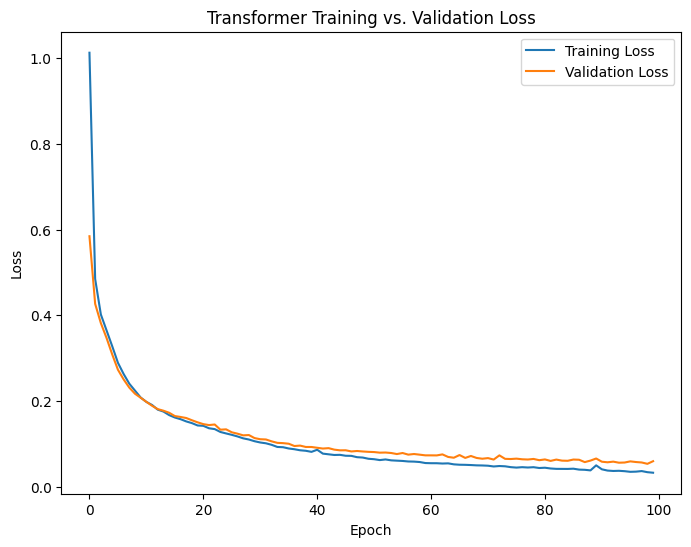

287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Example 1
Input Function:      -4*x**2
True Taylor:         -4*x**2
Predicted Taylor:    4*x**2
------------------------------
Example 2
Input Function:      -5*sin(x) + 2*sinh(x) - 2*atan(x)
True Taylor:         11*x**3/6 - 5*x
Predicted Taylor:    *xx**3/6 - 3*x
------------------------------
Example 3
Input Function:      -cosh(x) + 3*asin(x)
True Taylor:         -x**4/24 + x**3/2 - x**2/2 + 3*x - 1
Predicted Taylor:    ***4/24 + x**3/2 - x**2/2 + 3*x - 1
------------------------------
Example 4
Input Function:      5*acos(x)
True Taylor:         -5*x**3/6 - 5*x + 5*pi/2
Predicted Taylor:    **x**3/6 - 5*x + 5*pi/2
------------------------------
Example 5
Input Function:      -log(x + 1) + 3*asin(x)
True Taylor:         x**4/4 + x**3/6 + x**2/2 + 2*x
Predicted Taylor:    **4/4 + x**3/6 + x**2/2 + 2*x
------------------------------
Average BLEU Score on Test Set: 0.8930689371586087


In [6]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


plt.figure(figsize=(8, 6))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer Training vs. Validation Loss')
plt.legend()
plt.show()

# predictions
predictions = transformer_model.predict([input_sequences, output_sequences])
predicted_sequences = np.argmax(predictions, axis=-1)


# decode sequence back to strings
def decode_sequence(seq, tokenizer):
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    tokens = [reverse_word_index.get(num, '') for num in seq if num != 0]
    out_str = ''.join(tokens)
    # remove special tokens like '¶' or 'µ', remove them
    out_str = out_str.replace('¶', '').replace('µ', '')
    return out_str

# display some examples
num_examples = 5
for i in range(num_examples):
    input_str = decode_sequence(input_sequences[i], tokenizer)
    true_str = decode_sequence(output_sequences[i], tokenizer)
    pred_str = decode_sequence(predicted_sequences[i], tokenizer)
    print(f"Example {i+1}")
    print("Input Function:     ", input_str)
    print("True Taylor:        ", true_str)
    print("Predicted Taylor:   ", pred_str)
    print("-" * 30)


bleu_scores = []
# Smoothing helps avoid zero BLEU for short sequences
smooth_fn = SmoothingFunction().method1

for i in range(len(output_sequences)):
    # Prepare reference and candidate as lists of characters (for char-level)
    reference = [list(decode_sequence(output_sequences[i], tokenizer))]
    candidate = list(decode_sequence(predicted_sequences[i], tokenizer))
    score = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
    bleu_scores.append(score)

average_bleu = np.mean(bleu_scores)
print("Average BLEU Score on Test Set:", average_bleu)
